In [1]:
using DataFrames, CSV

┌ Info: Recompiling stale cache file /Users/aw/.julia/compiled/v1.1/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/aw/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


In [2]:
df = CSV.read("distributed_topsnr_1000_test.flagged.csv");

In [31]:
α = df.ra
δ = df.dec
r = hcat((cos.(α) .* cos.(δ)),
             (sin.(α) .* cos.(δ)),
             (sin.(δ)))
A = [0.0548755604162154 +0.4941094278755837 -0.8676661490190047
              -0.8734370902348850 -0.4448296299600112 -0.1980763734312015
              -0.4838350155487132 +0.7469822444972189 +0.4559837761750669]
rGal = r * A
X = rGal[:, 1]
Y = rGal[:, 2]
Z = rGal[:, 3]
;

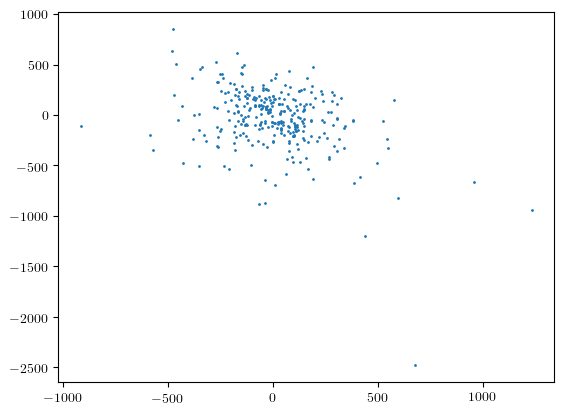

PyObject <matplotlib.collections.PathCollection object at 0x1441df5c0>

In [45]:
using PyPlot
mask = (.! (ismissing.(X) .| ismissing.(Y))) .& (df.logg .> 3)
plt.scatter(X[mask] .* df.rest[mask], Y[mask].* df.rest[mask], s=1)

In [51]:
msto = (.! ismissing.(df.logg)) .& (df.logg .< 4) .& (df.teff .> 5500);

In [60]:
wl_grid = load("wl_grid.jld2")["wl_grid"]
Δλ = 7                                                                          
    
li_air = 6707.85
include("air_vacuum.jl")
li_vac = air_to_vac(li_air)
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ
;

In [61]:
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) #gaussian kernel                       
n = sum(line_mask)
M = zeros(2 + n, n)                                                         
M[1, :] = ϕ.(wl_grid[line_mask], li_vac, li_air/3600)
M[1, :] ./= sqrt(sum(M[1, :].^2))
M[2, :] .= sqrt(1/n)
for i in 3:(2+n)
    M[i, i-2] = 1.
end 

In [69]:
function plot_spectrum(row)
    
    print("obsid: ", row.obsid)
    
    download_lamost_spectra([row.obsid], verbose=false)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    println(parse(Vector{Float64}, row.neighbors))
    #download_lamost_spectra(, verbose=false)
    F = hcat((n->load_lamost_spectrum(n)[2]).(row.neighbors)...)
    
    #figure(figsize=(3,3))
    #ylabel("residuals")
    #xlabel(L"$\lambda$ [\AA]")
    #errorbar(wl_grid[line_mask], row.diff, yerr=row.err, label="data")
    #errorbar(wl_grid[line_mask], M[1, :]*row.amplitude, label="best fit line model")
    #legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    plt.plot(wl, flux, label="data")
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl, flux, yerr=ivar.^(-1/2), label="data");
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    errorbar(wl_grid[line_mask], F[line_mask, :] * row.weights .- M[1, :]*row.amplitude, label="best fit residual model")
    legend()
    xlim(6660, 6750)
    ylim(0.9, 1.1)
    
    ;
end

plot_spectrum (generic function with 1 method)

In [70]:
include("get_lamost_spectra.jl")
i = rand(findall(msto))
plot_spectrum(df[i, :])

obsid: 399204185of 1 spectra, 0 need to be downloaded


MethodError: MethodError: no method matching parse(::Type{Array{Float64,1}}, ::String)
Closest candidates are:
  parse(!Matched::Type{LibGit2.GitCredential}, ::AbstractString) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/LibGit2/src/gitcredential.jl:73
  parse(!Matched::Type{LibGit2.GitCredentialHelper}, ::AbstractString) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/LibGit2/src/gitcredential.jl:163
  parse(!Matched::Type{Sockets.IPv4}, ::AbstractString) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Sockets/src/IPAddr.jl:166
  ...